## Library

In [2]:
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Prep

## Connection

In [3]:
con = SnowflakeTools(
    role="INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD",
    warehouse="INSIGHT_ANALYST_WH",
    database="BDWPRD_DE",
    schema="IA_MERCH_DE"
)

## Item list

In [4]:
# Load both AU and NZ sheets from the Excel file
item_list = pd.read_excel("Item list.xlsx", sheet_name=None)

# Replace sheet names if needed
au_items = item_list['AU']
nz_items = item_list['NZ']

# Standardise column names (optional but helpful)
au_items.columns = au_items.columns.str.strip().str.lower()
nz_items.columns = nz_items.columns.str.strip().str.lower()

# Ensure item_number is string with leading zeroes
au_items['item_number'] = au_items['item_number'].astype(str).str.zfill(7)
nz_items['item_number'] = nz_items['item_number'].astype(str).str.zfill(7)

In [5]:
# Read product hierarchy
product_hierarchy = con.read_sql_file_into_pandas(
    file="sql/item-hierarchy.sql"
)

snowflake_tools - 2025-06-13 15:06:31.948732+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-13 15:06:38.399608+10:00 - Saved token with '2025-06-13 19:06:38+10:00' expiry...


In [6]:
# Clean column names
product_hierarchy.columns = (
    product_hierarchy.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

# Ensure item_number is string with 7-digit padding
product_hierarchy['item_number'] = product_hierarchy['item_number'].astype(str).str.zfill(7)

In [7]:
# Merge enriched hierarchy into AU and NZ item lists
au_items_enriched = au_items.merge(product_hierarchy, on='item_number', how='left')
nz_items_enriched = nz_items.merge(product_hierarchy, on='item_number', how='left')


In [8]:
# Function to print unique values for each hierarchy column
def show_unique_hierarchy(df, label):
    print(f"\n🔹 {label}: Unique item_category_name")
    print(df['item_category_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_department_name")
    print(df['item_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_department_name")
    print(df['item_sub_department_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_class_name")
    print(df['item_class_name'].dropna().unique())

    print(f"\n🔹 {label}: Unique item_sub_class_name")
    print(df['item_sub_class_name'].dropna().unique())

# Show for both AU and NZ
show_unique_hierarchy(au_items_enriched, "AU ITEMS")
show_unique_hierarchy(nz_items_enriched, "NZ ITEMS")



🔹 AU ITEMS: Unique item_category_name
['200 TIMBER']

🔹 AU ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 AU ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 AU ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 AU ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS BULK STACK' '600 PANELS'
 '600 DRESSED PINE PNL BULK STCK']

🔹 NZ ITEMS: Unique item_category_name
['200 TIMBER']

🔹 NZ ITEMS: Unique item_department_name
['300 INDOOR TIMBER AND BOARDS']

🔹 NZ ITEMS: Unique item_sub_department_name
['400 PANELS']

🔹 NZ ITEMS: Unique item_class_name
['500 PANELS' '500 PANELS BULK STACK']

🔹 NZ ITEMS: Unique item_sub_class_name
['600 EXOTIC PANELS' '600 PANELS' '600 PANELS BULK STACK'
 '600 DRESSED PINE PNL BULK STCK']


## Timeline

In [9]:
start_date = "2024-08-26"
end_date = "2025-06-08"
start_rrp_date = "2025-03-03"

start_date_LY = "2023-08-27"
end_date_LY = "2024-06-09"
start_rrp_date_LY = "2024-03-04"

In [10]:
# Define time parameters and loyalty filter
params = {
    'AU': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
        'loyalty_filter': "AND stl.dw_loyalty_flybuys_account_id != MD5_BINARY(-1)",
        'product_group_items': "(" + ",".join([f"'{item}'" for item in au_items_enriched]) + ")"
    },
    'NZ': {
        'start_date': start_date,
        'end_date': end_date,
        'start_rrp_date': start_rrp_date,
        'start_date_LY': start_date_LY,
        'end_date_LY': end_date_LY,
        'start_rrp_date_LY': start_rrp_date_LY,
        'loyalty_filter': "",  
        'product_group_items': "(" + ",".join([f"'{item}'" for item in nz_items_enriched]) + ")"
    }
}

In [11]:
# Merchant Week Tagging Function
def tag_merchant_week(date, is_ly=False):
    date_obj = pd.to_datetime(date)
    ref_date = pd.to_datetime(start_date_LY if is_ly else start_date)
    delta_days = (date_obj - ref_date).days
    if 0 <= delta_days < 294:  # 42 weeks
        return str(9 + delta_days // 7).zfill(2)
    return None

# Class-based Performance

In [12]:
# Define reusable preparation function
def prepare_df(df, enriched_items, cutoff_date, year_label, country_label):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df['item_number'] = df['item_number'].astype(str).str.zfill(7)
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['rrp_increase'] = df['item_number'].isin(enriched_items['item_number']).map({True: 'Yes', False: 'No'})
    df['period'] = df['week_start'].apply(lambda x: 'Pre' if x < pd.to_datetime(cutoff_date) else 'Post')
    df['year_label'] = year_label
    df['country'] = country_label
    return df

In [13]:
df_all_list = []

for country, cfg in params.items():
    df_ty = con.read_sql_file_into_pandas(
    file="sql/class-transactions.sql",
    formatting={
        'start_date': f"'{cfg['start_date']}'",
        'end_date': f"'{cfg['end_date']}'",
        'country': f"'{country}'",
        'loyalty_filter': cfg['loyalty_filter']
        }
    )

    df_ly = con.read_sql_file_into_pandas(
        file="sql/class-transactions.sql",
        formatting={
            'start_date': f"'{cfg['start_date_LY']}'",
            'end_date': f"'{cfg['end_date_LY']}'",
            'country': f"'{country}'",
            'loyalty_filter': cfg['loyalty_filter']
        }
    )

    # Clean and tag
    df_ty = prepare_df(df_ty, au_items_enriched, cfg['start_rrp_date'], 'This Year', country)
    df_ly = prepare_df(df_ly, au_items_enriched, cfg['start_rrp_date_LY'], 'Last Year', country)

    # Add to list
    df_all_list.extend([df_ty, df_ly])

# ---- Combine all ----
df_all = pd.concat(df_all_list, ignore_index=True)

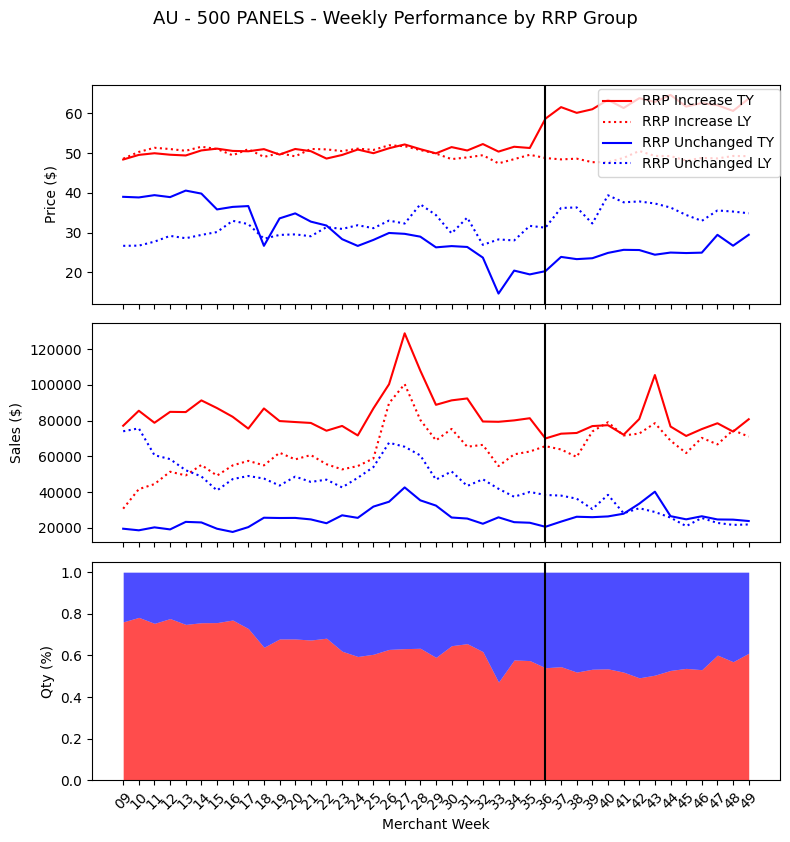

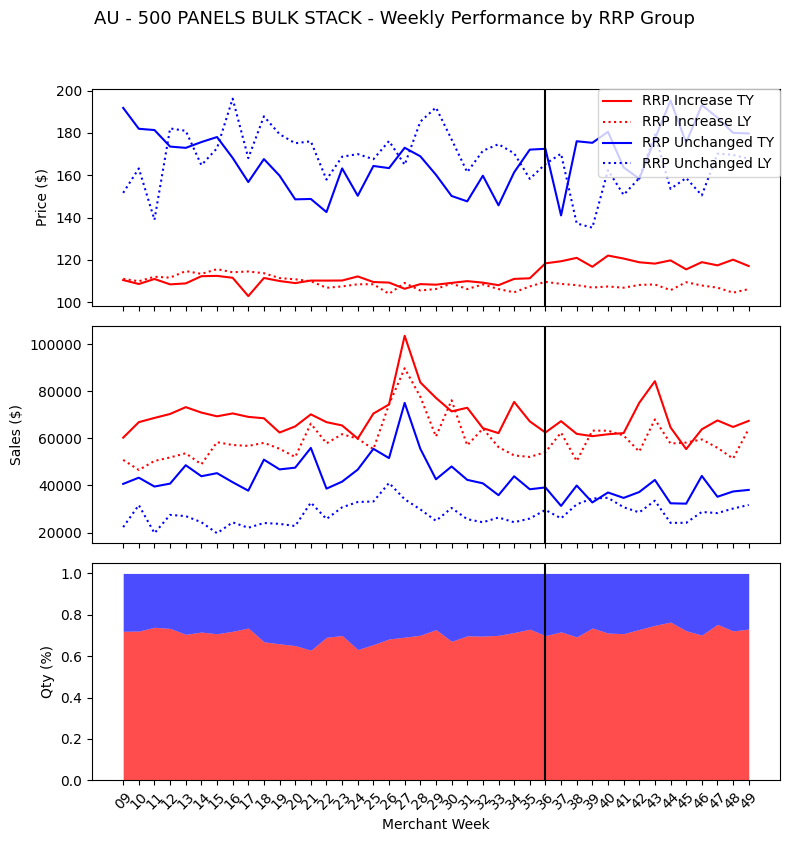

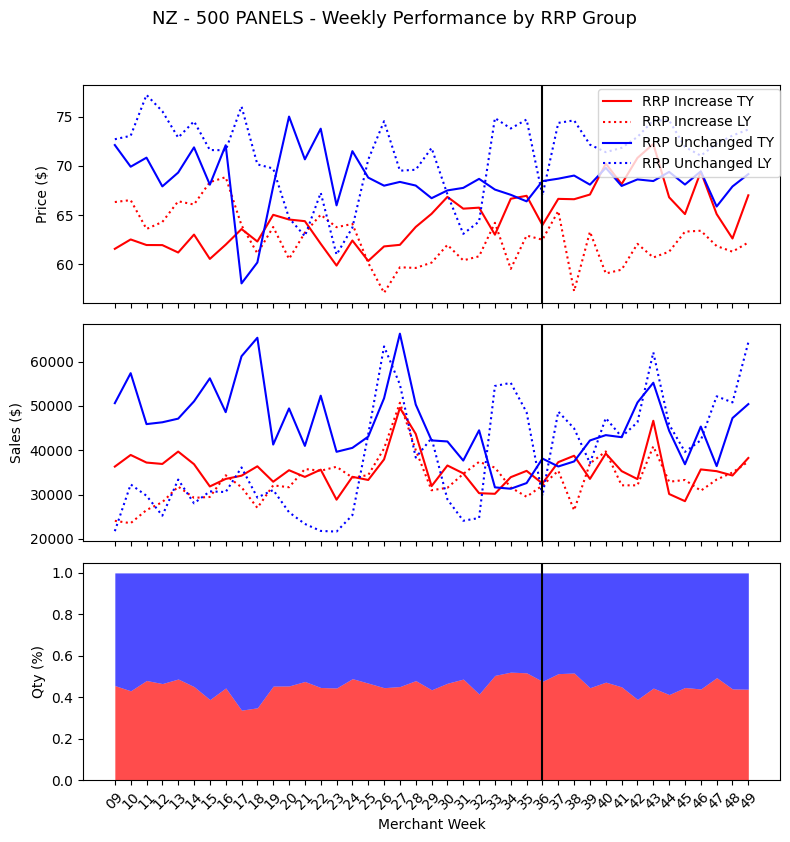

In [14]:
plot_colors = {'Yes': 'red', 'No': 'blue'}
line_styles = {'This Year': 'solid', 'Last Year': 'dotted'}
proportion = True  # Applies to total_quantity only

formatted_class_summaries = []

for (country, class_name), df_class in df_all.groupby(['country', 'item_class_name']):
    df_class = df_class.copy()

    # Assign merchant weeks
    df_class['merchant_week'] = df_class.apply(
        lambda row: tag_merchant_week(row['week_start'], is_ly=(row['year_label'] == 'Last Year')),
        axis=1
    )
    df_class = df_class[df_class['merchant_week'].notna()]

    # Weekly aggregate
    df_weekly = df_class.groupby(['merchant_week', 'rrp_increase', 'year_label'])[
        ['total_sales', 'total_quantity']
    ].sum().reset_index()

    # Weekly average price
    df_weekly['price'] = df_weekly['total_sales'] / df_weekly['total_quantity']
    df_weekly.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

    # Apply proportion if enabled (This Year only)
    if proportion:
        df_weekly['total_quantity'] = df_weekly.groupby(
            ['merchant_week', 'year_label']
        )['total_quantity'].transform(lambda x: x / x.sum())

    # Summary metrics table
    df_summary = df_class.groupby([
        'country', 'item_class_name', 'rrp_increase', 'period', 'year_label'
    ]).agg(
        total_sales=('total_sales', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        weeks=('week_start', pd.Series.nunique)
    ).reset_index()

    df_summary['avg_sales_per_week'] = (df_summary['total_sales'] / df_summary['weeks']).round(2)
    df_summary['avg_quantity_per_week'] = (df_summary['total_quantity'] / df_summary['weeks']).round(2)
    df_summary['avg_price'] = (df_summary['total_sales'] / df_summary['total_quantity']).round(2)
    df_summary = df_summary.drop(columns='weeks')
    formatted_class_summaries.append(df_summary)

    # Create figure: Price -> Sales -> Qty%
    fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)
    fig.suptitle(f"{country} - {class_name} - Weekly Performance by RRP Group", fontsize=13)

    # --- Plot 1: Price ---
    ax_price = axes[0]
    for rrp_status in ['Yes', 'No']:
        for year_label in ['This Year', 'Last Year']:
            subset = df_weekly[
                (df_weekly['rrp_increase'] == rrp_status) &
                (df_weekly['year_label'] == year_label)
            ]
            ax_price.plot(
                subset['merchant_week'],
                subset['price'],
                color=plot_colors[rrp_status],
                linestyle=line_styles[year_label]
            )
    ax_price.set_ylabel("Price ($)")
    ax_price.axvline(x='36', color='black')  
    ax_price.tick_params(axis='x', rotation=45)

    # --- Plot 2: Sales ---
    ax_sales = axes[1]
    for rrp_status in ['Yes', 'No']:
        for year_label in ['This Year', 'Last Year']:
            subset = df_weekly[
                (df_weekly['rrp_increase'] == rrp_status) &
                (df_weekly['year_label'] == year_label)
            ]
            ax_sales.plot(
                subset['merchant_week'],
                subset['total_sales'],
                label=f"{rrp_status} - {year_label}",
                color=plot_colors[rrp_status],
                linestyle=line_styles[year_label]
            )
    ax_sales.set_ylabel("Sales ($)")
    ax_sales.axvline(x='36', color='black')
    ax_sales.tick_params(axis='x', rotation=45)

    # --- Plot 3: Quantity % (This Year only) ---
    ax_qty = axes[2]
    df_ty_qty = df_weekly[df_weekly['year_label'] == 'This Year']
    df_pivot = df_ty_qty.pivot(index='merchant_week', columns='rrp_increase', values='total_quantity').fillna(0)

    df_pivot[['Yes', 'No']].plot.area(
        stacked=True,
        color=[plot_colors['Yes'], plot_colors['No']],
        ax=ax_qty,
        alpha=0.7,
        linewidth=0,
        legend=False
    )
    ax_qty.set_ylabel("Qty (%)")
    ax_qty.axvline(x='36', color='black')
    ax_qty.tick_params(axis='x', rotation=45)

    # X-axis config
    axes[-1].set_xlabel("Merchant Week")

    # Add one shared legend
    fig.legend(
        handles=[
            mlines.Line2D([], [], color='red', linestyle='solid', label='RRP Increase TY'),
            mlines.Line2D([], [], color='red', linestyle='dotted', label='RRP Increase LY'),
            mlines.Line2D([], [], color='blue', linestyle='solid', label='RRP Unchanged TY'),
            mlines.Line2D([], [], color='blue', linestyle='dotted', label='RRP Unchanged LY')
        ],
        bbox_to_anchor=(0.99, 0.9),
        ncol=1
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Combine final table
final_summary_table = pd.concat(formatted_class_summaries, ignore_index=True)

In [15]:
final_summary_table

,country,item_class_name,rrp_increase,period,year_label,total_sales,total_quantity,avg_sales_per_week,avg_quantity_per_week,avg_price
0,AU,500 PANELS,No,Post,Last Year,408273.35,11505.0,29162.38,821.79,35.49
1,AU,500 PANELS,No,Post,This Year,375248.92,14996.0,26803.49,1071.14,25.02
2,AU,500 PANELS,No,Pre,Last Year,1386240.80,45956.0,51342.25,1702.07,30.16
3,AU,500 PANELS,No,Pre,This Year,680398.05,23650.0,25199.93,875.93,28.77
4,AU,500 PANELS,Yes,Post,Last Year,978638.79,20044.0,69902.77,1431.71,48.82
5,AU,500 PANELS,Yes,Post,This Year,1085179.01,17484.0,77512.79,1248.86,62.07
6,AU,500 PANELS,Yes,Pre,Last Year,1617248.60,32205.0,59898.10,1192.78,50.22
7,AU,500 PANELS,Yes,Pre,This Year,2311483.82,45730.0,85610.51,1693.70,50.55
8,AU,500 PANELS BULK STACK,No,Post,Last Year,416813.87,2638.0,29772.42,188.43,158.00
9,AU,500 PANELS BULK STACK,No,Post,This Year,513977.41,2940.0,36712.67,210.00,174.82


# Cross shop Products

In [18]:
copurchase_frames = []

for country, cfg in params.items():
    # 1) Compute your ±10-week window
    rrp_dt       = datetime.strptime(cfg['start_rrp_date'], "%Y-%m-%d")
    window_start = (rrp_dt - timedelta(weeks=10)).strftime("%Y-%m-%d")
    window_end   = (rrp_dt + timedelta(weeks=10)).strftime("%Y-%m-%d")

    # 2) Build seed‐item tuple
    items = (
      au_items_enriched['item_number'].astype(str).unique().tolist()
      if country=='AU' else
      nz_items_enriched['item_number'].astype(str).unique().tolist()
    )
    items_tuple = "(" + ",".join(f"'{item}'" for item in items) + ")"

    # 3) Execute SQL
    df = con.read_sql_file_into_pandas(
        file="sql/copurchases.sql",
        formatting={
            'start_date'          : f"'{window_start}'",
            'end_date'            : f"'{window_end}'",
            'country'             : f"'{country}'",
            'loyalty_filter'      : cfg['loyalty_filter'],
            'product_group_items' : items_tuple
        }
    )

    # 4) Tag country
    df['country'] = country
    copurchase_frames.append(df)

copurchase_df = pd.concat(copurchase_frames, ignore_index=True)
output_path = 'copurchase_results.csv'
copurchase_df.to_csv(output_path, index=False)

# Basket

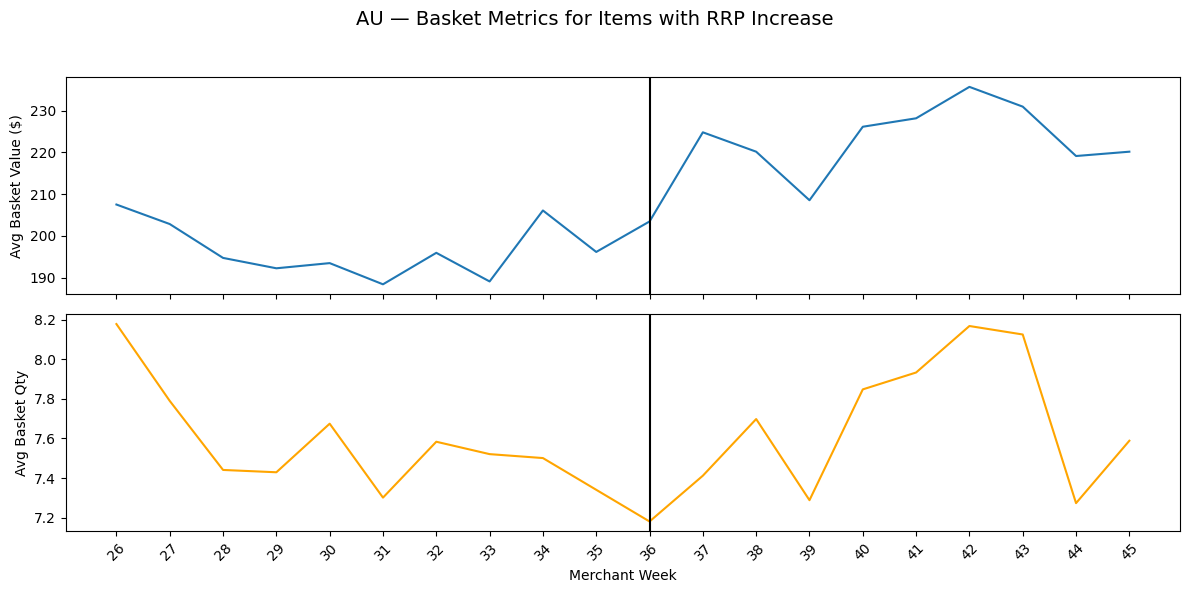

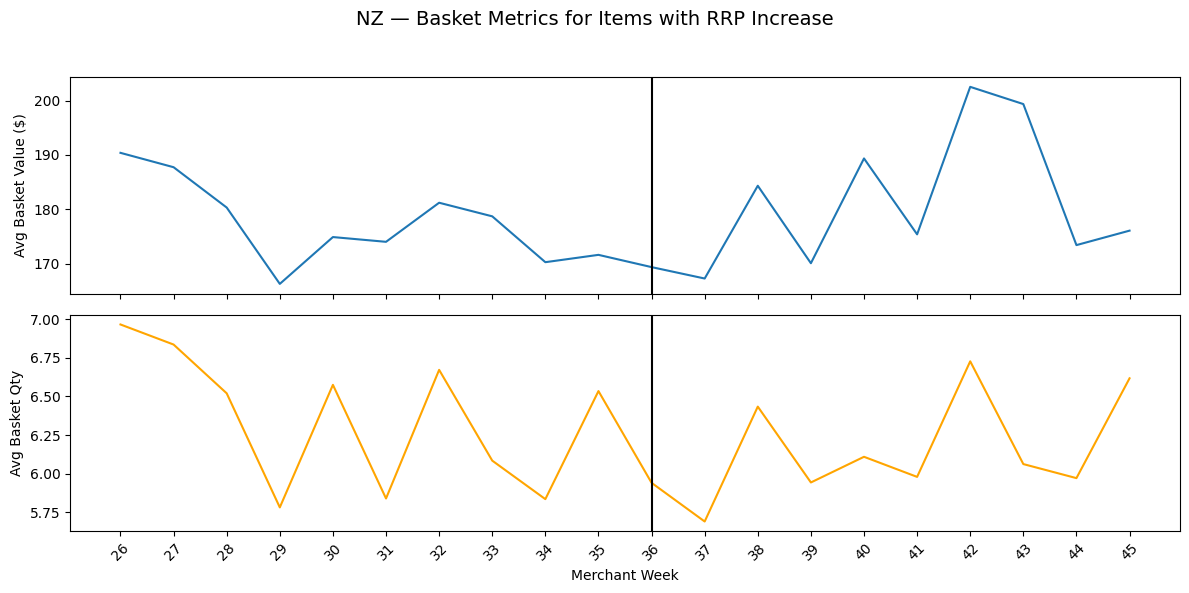

In [34]:
copurchase_frames = []

for country, cfg in params.items():
    # Build ±10-week window
    rrp_dt       = datetime.strptime(cfg['start_rrp_date'], "%Y-%m-%d")
    window_start = (rrp_dt - timedelta(weeks=10)).strftime("%Y-%m-%d")
    window_end   = (rrp_dt + timedelta(weeks=10)).strftime("%Y-%m-%d")

    # Build seed‐item tuple
    items = (
        au_items_enriched['item_number'].astype(str).unique().tolist()
        if country == 'AU'
        else nz_items_enriched['item_number'].astype(str).unique().tolist()
    )
    items_tuple = "(" + ",".join(f"'{itm}'" for itm in items) + ")"

    # Read basket metrics
    df = con.read_sql_file_into_pandas(
        file="sql/basket-metrics.sql",
        formatting={
            'start_date'          : f"'{window_start}'",
            'end_date'            : f"'{window_end}'",
            'country'             : f"'{country}'",
            'loyalty_filter'      : cfg['loyalty_filter'],
            'product_group_items' : items_tuple
        }
    )
    # normalize columns
    df.columns = df.columns.str.lower()

    # create the shared-x figure
    fig, (ax_val, ax_qty) = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    fig.suptitle(f"{country} — Basket Metrics for Items with RRP Increase", fontsize=14)

    # Top: avg basket value
    ax_val.plot(df['merchant_week'], df['avg_basket_value'], linestyle='-')
    ax_val.axvline(x=36, color='black')
    ax_val.set_ylabel("Avg Basket Value ($)")
    ax_val.grid(False)

    # Bottom: avg basket qty
    ax_qty.plot(df['merchant_week'], df['avg_basket_qty'], color='orange', linestyle='-')
    ax_qty.axvline(x=36, color='black')
    ax_qty.set_ylabel("Avg Basket Qty")
    ax_qty.set_xlabel("Merchant Week")
    ax_qty.grid(False)

    # X-ticks
    ax_qty.set_xticks(df['merchant_week'])
    ax_qty.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()